# **FLUX UPSCALER FOR IMAGES & VIDEOS (Local - RTX 5060 Ti)**

Adapted from the original Colab notebook for local Windows execution with RTX 5060 Ti.

## Setup Instructions
1. Run the **Setup Environment** cell first (only needed once)
2. Set your `INPUT_IMAGE_PATH` in the **Configuration** cell
3. Adjust upscale settings as needed
4. Run the **Upscale** cell

## Notes
- Models are downloaded to `./hf/` directory (relative to this repo)
- Output is saved to the repo root directory
- For 8GB VRAM variant, reduce `tile_width` and `tile_height` to 384 or 256
- The 16GB variant should handle default settings fine

In [1]:
# @title Setup Environment (Run Once)
import subprocess
import sys
import os
from pathlib import Path

# Get repo root (parent of resolution-upscaling folder)
NOTEBOOK_DIR = Path(os.getcwd()).resolve()
if NOTEBOOK_DIR.name == "resolution-upscaling":
    REPO_ROOT = NOTEBOOK_DIR.parent
else:
    REPO_ROOT = NOTEBOOK_DIR

# Directory paths
HF_DIR = REPO_ROOT / "hf"
COMFYUI_DIR = HF_DIR / "ComfyUI"
MODELS_DIR = HF_DIR / "models"
OUTPUT_DIR = REPO_ROOT / "output"
INPUT_DIR = REPO_ROOT / "input"

# Create directories
for d in [HF_DIR, MODELS_DIR, OUTPUT_DIR, INPUT_DIR, 
          MODELS_DIR / "upscale_models", MODELS_DIR / "unet", 
          MODELS_DIR / "vae", MODELS_DIR / "clip", MODELS_DIR / "loras"]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Repo root: {REPO_ROOT}")
print(f"Models directory: {MODELS_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

def install_pip_packages():
    # Install PyTorch NIGHTLY with CUDA 12.8 (required for RTX 5060 Ti sm_120 Blackwell)
    print("Installing PyTorch nightly with CUDA 12.8 (for RTX 50-series)...")
    result = subprocess.run(
        [sys.executable, '-m', 'pip', 'install', '-q', '--pre',
         'torch', 'torchvision', 'torchaudio',
         '--index-url', 'https://download.pytorch.org/whl/nightly/cu128'],
        capture_output=True
    )
    if result.returncode == 0:
        print("✓ PyTorch nightly with CUDA 12.8 installed")
    else:
        print(f"✗ PyTorch install failed: {result.stderr.decode()}")
        raise RuntimeError("PyTorch CUDA installation failed")
    
    # Other packages (xformers removed - optional and causes conflicts)
    packages = [
        'torchsde',
        'av',
        'diffusers',
        'accelerate',
        'einops',
        'spandrel',
        'opencv-python',
        'imageio',
        'imageio-ffmpeg',
        'huggingface_hub',
        'safetensors',
        'gguf',
        'sentencepiece',
    ]

    for package in packages:
        try:
            subprocess.run(
                [sys.executable, '-m', 'pip', 'install', '-q', package],
                check=True,
                capture_output=True
            )
            print(f"✓ {package} installed")
        except subprocess.CalledProcessError as e:
            print(f"✗ Error installing {package}: {e.stderr.decode().strip() or 'Unknown error'}")

print("Installing pip packages...")
install_pip_packages()

# Clone ComfyUI and custom nodes if not present
if not COMFYUI_DIR.exists():
    print("Cloning ComfyUI...")
    subprocess.run(['git', 'clone', 'https://github.com/Isi-dev/ComfyUI', str(COMFYUI_DIR)], check=True)
    
custom_nodes_dir = COMFYUI_DIR / "custom_nodes"
custom_nodes_dir.mkdir(exist_ok=True)

if not (custom_nodes_dir / "ComfyUI_GGUF").exists():
    print("Cloning ComfyUI_GGUF...")
    subprocess.run(['git', 'clone', 'https://github.com/Isi-dev/ComfyUI_GGUF.git'], cwd=str(custom_nodes_dir), check=True)
    # Install GGUF requirements
    req_file = custom_nodes_dir / "ComfyUI_GGUF" / "requirements.txt"
    if req_file.exists():
        subprocess.run([sys.executable, '-m', 'pip', 'install', '-q', '-r', str(req_file)], check=True)

if not (custom_nodes_dir / "ComfyUI_UltimateSDUpscale").exists():
    print("Cloning ComfyUI_UltimateSDUpscale...")
    subprocess.run(['git', 'clone', 'https://github.com/Isi-dev/ComfyUI_UltimateSDUpscale'], cwd=str(custom_nodes_dir), check=True)

print("\n✅ Environment Setup Complete!")

Repo root: C:\Users\Armaan\Desktop\Artinafti
Models directory: C:\Users\Armaan\Desktop\Artinafti\hf\models
Output directory: C:\Users\Armaan\Desktop\Artinafti\output
Installing pip packages...
Installing PyTorch nightly with CUDA 12.8 (for RTX 50-series)...
✓ PyTorch nightly with CUDA 12.8 installed
✓ torchsde installed
✓ av installed
✓ diffusers installed
✓ accelerate installed
✓ einops installed
✓ spandrel installed
✓ opencv-python installed
✓ imageio installed
✓ imageio-ffmpeg installed
✓ huggingface_hub installed
✓ safetensors installed
✓ gguf installed
✓ sentencepiece installed

✅ Environment Setup Complete!


In [2]:
# @title Download Models (Run Once)
import os
from pathlib import Path
from huggingface_hub import hf_hub_download

# Get paths from previous cell
NOTEBOOK_DIR = Path(os.getcwd()).resolve()
if NOTEBOOK_DIR.name == "resolution-upscaling":
    REPO_ROOT = NOTEBOOK_DIR.parent
else:
    REPO_ROOT = NOTEBOOK_DIR

HF_DIR = REPO_ROOT / "hf"
MODELS_DIR = HF_DIR / "models"

# Create model subdirectories
UPSCALE_MODELS_DIR = MODELS_DIR / "upscale_models"
UNET_DIR = MODELS_DIR / "unet"
VAE_DIR = MODELS_DIR / "vae"
CLIP_DIR = MODELS_DIR / "clip"
LORAS_DIR = MODELS_DIR / "loras"

for d in [UPSCALE_MODELS_DIR, UNET_DIR, VAE_DIR, CLIP_DIR, LORAS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Configuration
download_face_upscalers = False  # Set to True if you want face upscalers
download_loRA = False  # Set to True if you want LoRA

def download_model(repo_id: str, filename: str, dest_dir: Path, subfolder: str = None) -> str:
    """Download model from HuggingFace Hub."""
    dest_path = dest_dir / filename
    if dest_path.exists():
        print(f"✓ {filename} already exists")
        return filename
    
    try:
        print(f"Downloading {filename}...", end=' ', flush=True)
        hf_hub_download(
            repo_id=repo_id,
            filename=filename if subfolder is None else f"{subfolder}/{filename}",
            local_dir=str(dest_dir),
            local_dir_use_symlinks=False
        )
        # Move file if it was downloaded to subfolder
        if subfolder:
            src = dest_dir / subfolder / filename
            if src.exists():
                src.rename(dest_path)
                (dest_dir / subfolder).rmdir()
        print("Done!")
        return filename
    except Exception as e:
        print(f"\nError downloading {filename}: {e}")
        return None

print("Downloading upscale models...")
x_UltraSharp = download_model("Isi99999/Upscalers", "4x-UltraSharp.pth", UPSCALE_MODELS_DIR)
x_foolhardy_Remacri = download_model("Isi99999/Upscalers", "4x_foolhardy_Remacri.pth", UPSCALE_MODELS_DIR)
x_AnimeSharp = download_model("Isi99999/Upscalers", "4x-AnimeSharp.pth", UPSCALE_MODELS_DIR)

if download_face_upscalers:
    x_FaceUpSharpDAT = download_model("Isi99999/Upscalers", "4xFaceUpSharpDAT.pth", UPSCALE_MODELS_DIR)
    x_FaceUpSharpLDAT = download_model("Isi99999/Upscalers", "4xFaceUpSharpLDAT.safetensors", UPSCALE_MODELS_DIR)

print("\nDownloading FLUX model...")
flux_model = download_model("city96/FLUX.1-dev-gguf", "flux1-dev-Q8_0.gguf", UNET_DIR)

print("\nDownloading VAE...")
flux_vae = download_model("Isi99999/Upscalers", "ae.sft", VAE_DIR, subfolder="Flux")

print("\nDownloading CLIP models...")
flux_clip_l = download_model("Isi99999/Upscalers", "clip_l.safetensors", CLIP_DIR, subfolder="Flux")
flux_t5xxl = download_model("Isi99999/Upscalers", "t5xxl_fp8_e4m3fn.safetensors", CLIP_DIR, subfolder="Flux")

if download_loRA:
    print("\nDownloading LoRA...")
    flux_lora = download_model("Isi99999/Upscalers", "flux_realism_lora.safetensors", LORAS_DIR, subfolder="Flux")

print("\n✅ All models downloaded!")

✓ 4x-UltraSharp.pth already exists
✓ 4x_foolhardy_Remacri.pth already exists
✓ 4x-AnimeSharp.pth already exists

✓ flux1-dev-Q8_0.gguf already exists

✓ ae.sft already exists

✓ clip_l.safetensors already exists
✓ t5xxl_fp8_e4m3fn.safetensors already exists

✅ All models downloaded!


In [3]:
# @title Load Libraries and Initialize
import torch
import numpy as np
from PIL import Image
import gc
import os
import sys
import random
import imageio
import cv2
import shutil
import datetime
from pathlib import Path
from IPython.display import display, HTML, Image as IPImage

# Set up paths
NOTEBOOK_DIR = Path(os.getcwd()).resolve()
if NOTEBOOK_DIR.name == "resolution-upscaling":
    REPO_ROOT = NOTEBOOK_DIR.parent
else:
    REPO_ROOT = NOTEBOOK_DIR

HF_DIR = REPO_ROOT / "hf"
COMFYUI_DIR = HF_DIR / "ComfyUI"
MODELS_DIR = HF_DIR / "models"
OUTPUT_DIR = REPO_ROOT / "output"
INPUT_DIR = REPO_ROOT / "input"

# Model paths
UPSCALE_MODELS_DIR = MODELS_DIR / "upscale_models"
UNET_DIR = MODELS_DIR / "unet"
VAE_DIR = MODELS_DIR / "vae"
CLIP_DIR = MODELS_DIR / "clip"
LORAS_DIR = MODELS_DIR / "loras"

# Add ComfyUI to path
sys.path.insert(0, str(COMFYUI_DIR))

# Configure ComfyUI folder_paths to use our custom model directories
import folder_paths
folder_paths.folder_names_and_paths["text_encoders"] = ([str(CLIP_DIR)], folder_paths.supported_pt_extensions)
folder_paths.folder_names_and_paths["clip"] = ([str(CLIP_DIR)], folder_paths.supported_pt_extensions)
folder_paths.folder_names_and_paths["vae"] = ([str(VAE_DIR)], folder_paths.supported_pt_extensions)
folder_paths.folder_names_and_paths["diffusion_models"] = ([str(UNET_DIR)], folder_paths.supported_pt_extensions)
folder_paths.folder_names_and_paths["unet"] = ([str(UNET_DIR)], folder_paths.supported_pt_extensions)
folder_paths.folder_names_and_paths["upscale_models"] = ([str(UPSCALE_MODELS_DIR)], folder_paths.supported_pt_extensions)
folder_paths.folder_names_and_paths["loras"] = ([str(LORAS_DIR)], folder_paths.supported_pt_extensions)

# Import ComfyUI modules
from nodes import (
    DualCLIPLoader,
    UNETLoader,
    VAELoader,
    LoraLoaderModelOnly,
    LoadImage,
    SaveImage
)

from custom_nodes.ComfyUI_GGUF.nodes import UnetLoaderGGUF
from comfy_extras.nodes_upscale_model import UpscaleModelLoader
from comfy_extras.nodes_flux import CLIPTextEncodeFlux
from custom_nodes.ComfyUI_UltimateSDUpscale.nodes import (
    UltimateSDUpscale,
    UltimateSDUpscaleNoUpscale
)

# Model filenames
flux_model = "flux1-dev-Q8_0.gguf"
flux_vae = "ae.sft"
flux_clip_l = "clip_l.safetensors"
flux_t5xxl = "t5xxl_fp8_e4m3fn.safetensors"
lora = None  # Set if using LoRA

# Initialize loaders
clip_loader = DualCLIPLoader()
unet_loader = UnetLoaderGGUF()
vae_loader = VAELoader()
load_lora = LoraLoaderModelOnly()
load_image = LoadImage()
save_image = SaveImage()
upscale_model_loader = UpscaleModelLoader()
positive_prompt_encode = CLIPTextEncodeFlux()
negative_prompt_encode = CLIPTextEncodeFlux()
upscaler = UltimateSDUpscale()
noUpscale = UltimateSDUpscaleNoUpscale()

# Helper functions
def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    gc.collect()

def save_as_image(image, filename_prefix, output_dir=None):
    """Save single frame as PNG image."""
    if output_dir is None:
        output_dir = OUTPUT_DIR
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    output_path = output_dir / f"{filename_prefix}.png"

    frame = (image.cpu().numpy() * 255).astype(np.uint8)
    Image.fromarray(frame).save(str(output_path))

    return str(output_path)

def save_as_mp4(images, filename_prefix, fps, output_dir=None):
    """Save frames as MP4 video."""
    if output_dir is None:
        output_dir = OUTPUT_DIR
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    output_path = output_dir / f"{filename_prefix}.mp4"

    frames = []
    for i, img in enumerate(images):
        try:
            if isinstance(img, torch.Tensor):
                img = img.cpu().numpy()

            if img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)

            if len(img.shape) == 4:
                img = img[0]

            if len(img.shape) == 3:
                if img.shape[0] in (1, 3, 4):
                    img = np.transpose(img, (1, 2, 0))
                elif img.shape[2] > 4:
                    img = img[:, :, :3]
            elif len(img.shape) == 2:
                img = np.expand_dims(img, axis=-1)

            if len(img.shape) != 3 or img.shape[2] not in (1, 3, 4):
                raise ValueError(f"Invalid frame shape after processing: {img.shape}")

            frames.append(img)
        except Exception as e:
            print(f"Error processing frame {i}: {str(e)}")
            raise

    with imageio.get_writer(str(output_path), fps=fps) as writer:
        for frame in frames:
            writer.append_data(frame)

    return str(output_path)

def extract_frames(video_path, max_frames=None):
    """Extract frames from video and return as a list of images."""
    vidcap = cv2.VideoCapture(str(video_path))
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    frames = []

    while True:
        success, frame = vidcap.read()
        if not success or (max_frames and len(frames) >= max_frames):
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    vidcap.release()
    if not frames:
        return None, fps

    print(f"Extracted {len(frames)} frames")
    return frames, fps

def select_every_n_frame(frames, fps, n, skip_first=0, max_output_frames=0):
    """Select every nth frame from video."""
    if not frames or n < 1:
        raise ValueError("Frames must be a non-empty list and n must be >= 1")

    frames_to_use = frames[skip_first:]
    if not frames_to_use:
        print("No frames available after skipping.")
        return [], 0.0

    selected_frames = frames_to_use[::n]
    if max_output_frames != 0 and len(selected_frames) > max_output_frames:
        selected_frames = selected_frames[:max_output_frames]

    adjusted_fps = fps / n
    print(f"Adjusted FPS: {adjusted_fps:.2f} -> Final output: {len(selected_frames)} frames")

    return selected_frames, adjusted_fps

def display_video(video_path):
    """Display video in notebook."""
    from base64 import b64encode

    video_data = open(video_path, 'rb').read()
    if video_path.lower().endswith('.mp4'):
        mime_type = "video/mp4"
    elif video_path.lower().endswith('.webm'):
        mime_type = "video/webm"
    else:
        mime_type = "video/mp4"

    data_url = f"data:{mime_type};base64," + b64encode(video_data).decode()
    display(HTML(f"""
    <video width=512 controls autoplay loop>
        <source src="{data_url}" type="{mime_type}">
    </video>
    """))

def remove_frame(image_path: str, threshold: float = 0.15, min_frame_width: int = 10, max_frame_width: int = 200) -> str:
    """
    Remove frame/border from an image by detecting and cropping out the frame.
    
    Uses edge detection and variance analysis to find where the frame ends and content begins.
    
    Args:
        image_path: Path to input image
        threshold: Edge detection threshold (0.0-1.0), lower = more sensitive
        min_frame_width: Minimum expected frame width in pixels
        max_frame_width: Maximum expected frame width in pixels
    
    Returns:
        Path to the cropped image (saves to same location with '_no_frame' suffix)
    """
    image_path = Path(image_path)
    if not image_path.exists():
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    # Load image
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    original_height, original_width = img.shape[:2]
    
    # Convert to grayscale for analysis
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    def find_frame_edge(scan_range: int, is_horizontal: bool, from_start: bool) -> int:
        """
        Find frame edge by scanning from edge inward.
        
        Args:
            scan_range: How many pixels to scan from the edge
            is_horizontal: True for top/bottom edges, False for left/right
            from_start: True for top/left, False for bottom/right
        
        Returns:
            Pixel position where content starts (frame ends)
        """
        strip_width = 10
        max_variance_pos = 0
        max_variance = 0
        
        if is_horizontal:
            if from_start:
                # Scan from top
                for y in range(0, min(scan_range, original_height - strip_width), 2):
                    strip = gray[y:y+strip_width, :]
                    variance = np.var(strip)
                    if variance > max_variance:
                        max_variance = variance
                        max_variance_pos = y
            else:
                # Scan from bottom
                for y in range(original_height - min(scan_range, original_height), original_height - strip_width, -2):
                    strip = gray[y:y+strip_width, :]
                    variance = np.var(strip)
                    if variance > max_variance:
                        max_variance = variance
                        max_variance_pos = y
        else:
            if from_start:
                # Scan from left
                for x in range(0, min(scan_range, original_width - strip_width), 2):
                    strip = gray[:, x:x+strip_width]
                    variance = np.var(strip)
                    if variance > max_variance:
                        max_variance = variance
                        max_variance_pos = x
            else:
                # Scan from right
                for x in range(original_width - min(scan_range, original_width), original_width - strip_width, -2):
                    strip = gray[:, x:x+strip_width]
                    variance = np.var(strip)
                    if variance > max_variance:
                        max_variance = variance
                        max_variance_pos = x
        
        return max_variance_pos
    
    # Find frame edges
    scan_range = min(max_frame_width, original_width // 3, original_height // 3)
    
    top = find_frame_edge(scan_range, True, True)
    bottom = find_frame_edge(scan_range, True, False)
    left = find_frame_edge(scan_range, False, True)
    right = find_frame_edge(scan_range, False, False)
    
    # Ensure minimum frame width
    if top < min_frame_width:
        top = min_frame_width
    if left < min_frame_width:
        left = min_frame_width
    if original_height - bottom < min_frame_width:
        bottom = original_height - min_frame_width
    if original_width - right < min_frame_width:
        right = original_width - min_frame_width
    
    # Ensure valid bounds
    top = max(0, min(top, original_height - 20))
    bottom = max(top + 20, min(bottom, original_height))
    left = max(0, min(left, original_width - 20))
    right = max(left + 20, min(right, original_width))
    
    # Validate crop size (must be at least 50% of original)
    content_width = right - left
    content_height = bottom - top
    
    if content_width < original_width * 0.5 or content_height < original_height * 0.5:
        # Fallback: conservative crop (remove 3% from each side)
        margin = min(original_width, original_height) // 30
        top = margin
        bottom = original_height - margin
        left = margin
        right = original_width - margin
        print("Warning: Frame detection may have failed, using conservative crop")
    
    # Crop the image
    cropped = img[top:bottom, left:right]
    
    # Save cropped image
    output_path = image_path.parent / f"{image_path.stem}_no_frame{image_path.suffix}"
    cv2.imwrite(str(output_path), cropped)
    
    print(f"Removed frame: cropped from {original_width}x{original_height} to {content_width}x{content_height}")
    print(f"Removed margins: top={top}, bottom={original_height-bottom}, left={left}, right={original_width-right}")
    
    return str(output_path)

print(f"✅ Libraries loaded!")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

✅ Libraries loaded!
CUDA available: True
GPU: NVIDIA GeForce RTX 5060 Ti
VRAM: 15.9 GB


In [4]:
# @title Configuration

# ============== INPUT ==============
# Set path to your input image or video
# Can be absolute path or relative to repo root
INPUT_IMAGE_PATH = "input/2WallartAbstract3.06.png"

# ============== FRAME REMOVAL SETTINGS ==============
remove_frame_before_upscale = True  # Set to True to automatically remove frames/borders before upscaling
frame_removal_threshold = 0.15  # Edge detection sensitivity (0.0-1.0, lower = more sensitive)
min_frame_width = 10  # Minimum expected frame width in pixels
max_frame_width = 200  # Maximum expected frame width in pixels

# ============== PROMPT SETTINGS ==============
positive_prompt = ""  # Optional, may improve results
positive_prompt2 = ""
negative_prompt = ""
negative_prompt2 = ""
guidance = 3.5

# ============== UPSCALE SETTINGS ==============
upscale_by = 2  # Scale factor (0.05 to 4.0)
seed = 0  # 0 = random seed
steps = 20  # Recommended: 20x denoise value
cfg = 7
sampler_name = "euler"  # Options: euler, dpmpp_2m, dpmpp_sde, etc.
scheduler = "normal"  # Options: normal, karras, exponential, etc.
denoise = 0.2  # Higher = more AI regeneration (0.0 to 1.0)

# Upscale model options:
# "4x-UltraSharp.pth", "4x_foolhardy_Remacri.pth", "4x-AnimeSharp.pth"
# "4xFaceUpSharpDAT.pth", "4xFaceUpSharpLDAT.safetensors" (if downloaded)
upscale_model = "4x-UltraSharp.pth"

# ============== TILE SETTINGS ==============
# For 8GB VRAM: use 384 or 256
# For 16GB VRAM: 512 is fine
mode_type = "Linear"  # Linear, Chess, None
tile_width = 512
tile_height = 512
mask_blur = 8
tile_padding = 32

# ============== SEAM FIX SETTINGS ==============
seam_fix_mode = "None"  # None, Half Tile, Half Tile + Intersections, Band Pass
seam_fix_denoise = 1.0
seam_fix_width = 64
seam_fix_mask_blur = 8
seam_fix_padding = 16
force_uniform_tiles = True
tiled_decode = False

# ============== LoRA SETTINGS ==============
use_loRA = False
LoRA_Strength = 1.0

# ============== VIDEO SETTINGS ==============
select_every_nth_frame = 1  # Process every Nth frame (1 = all frames)
skip_first_frames = 0
max_output_frames = 0  # 0 = no limit

# ============== OUTPUT SETTINGS ==============
overwrite_previous_output = False

print("Configuration set!")
print(f"Input: {INPUT_IMAGE_PATH}")
print(f"Upscale by: {upscale_by}x")
print(f"Denoise: {denoise}")
print(f"Steps: {steps}")

Configuration set!
Input: input/2WallartAbstract3.06.png
Upscale by: 2x
Denoise: 0.2
Steps: 20


Using seed: 3413158271
Processing: C:\Users\Armaan\Desktop\Artinafti\input\2WallartAbstract3.06.png
Removing frame from image...
Loading Text_Encoder...


Loading Unet Model...
gguf qtypes: F16 (476), Q8_0 (304)
Loading upscale model...


C:\Users\Armaan\Desktop\Artinafti\hf\ComfyUI\custom_nodes\ComfyUI_GGUF\loader.py:91: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:219.)
  torch_tensor = torch.from_numpy(tensor.data) # mmap


Loading VAE...
Upscaling image...
Canva size: 2248x2248
Image size: 1124x1124
Tile size: 512x512
Tiles amount: 25
Grid: 5x5


USDU:   0%|                                                                                                       | 0/9 [00:00<?, ?tile/s]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU:  11%|██████████▌                                                                                    | 1/9 [00:40<05:23, 40.45s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU:  22%|█████████████████████                                                                          | 2/9 [01:09<03:57, 33.95s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU:  33%|███████████████████████████████▋                                                               | 3/9 [01:39<03:11, 31.86s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU:  44%|██████████████████████████████████████████▏                                                    | 4/9 [02:08<02:33, 30.79s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU:  56%|████████████████████████████████████████████████████▊                                          | 5/9 [02:37<02:01, 30.28s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU:  67%|███████████████████████████████████████████████████████████████▎                               | 6/9 [03:07<01:29, 29.97s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU:  78%|█████████████████████████████████████████████████████████████████████████▉                     | 7/9 [03:36<00:59, 29.74s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU:  89%|████████████████████████████████████████████████████████████████████████████████████▍          | 8/9 [04:05<00:29, 29.62s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:35<00:00, 29.53s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU: 10tile [05:04, 29.49s/tile]                                                                                                         

  0%|          | 0/20 [00:00<?, ?it/s]

USDU: 11tile [05:33, 29.46s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU: 12tile [06:03, 29.46s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU: 13tile [06:32, 29.42s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU: 14tile [07:02, 29.40s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU: 15tile [07:31, 29.38s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU: 16tile [08:00, 29.36s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU: 17tile [08:30, 29.35s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU: 18tile [08:59, 29.35s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU: 19tile [09:28, 29.31s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU: 20tile [09:57, 29.22s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU: 21tile [10:26, 29.20s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU: 22tile [10:56, 29.27s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU: 23tile [11:25, 29.29s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU: 24tile [11:54, 29.26s/tile]

  0%|          | 0/20 [00:00<?, ?it/s]

USDU: 25tile [12:24, 29.76s/tile]


Saving as PNG image...
Saved to: C:\Users\Armaan\Desktop\Artinafti\output\2WallartAbstract3.06-upscaled.png


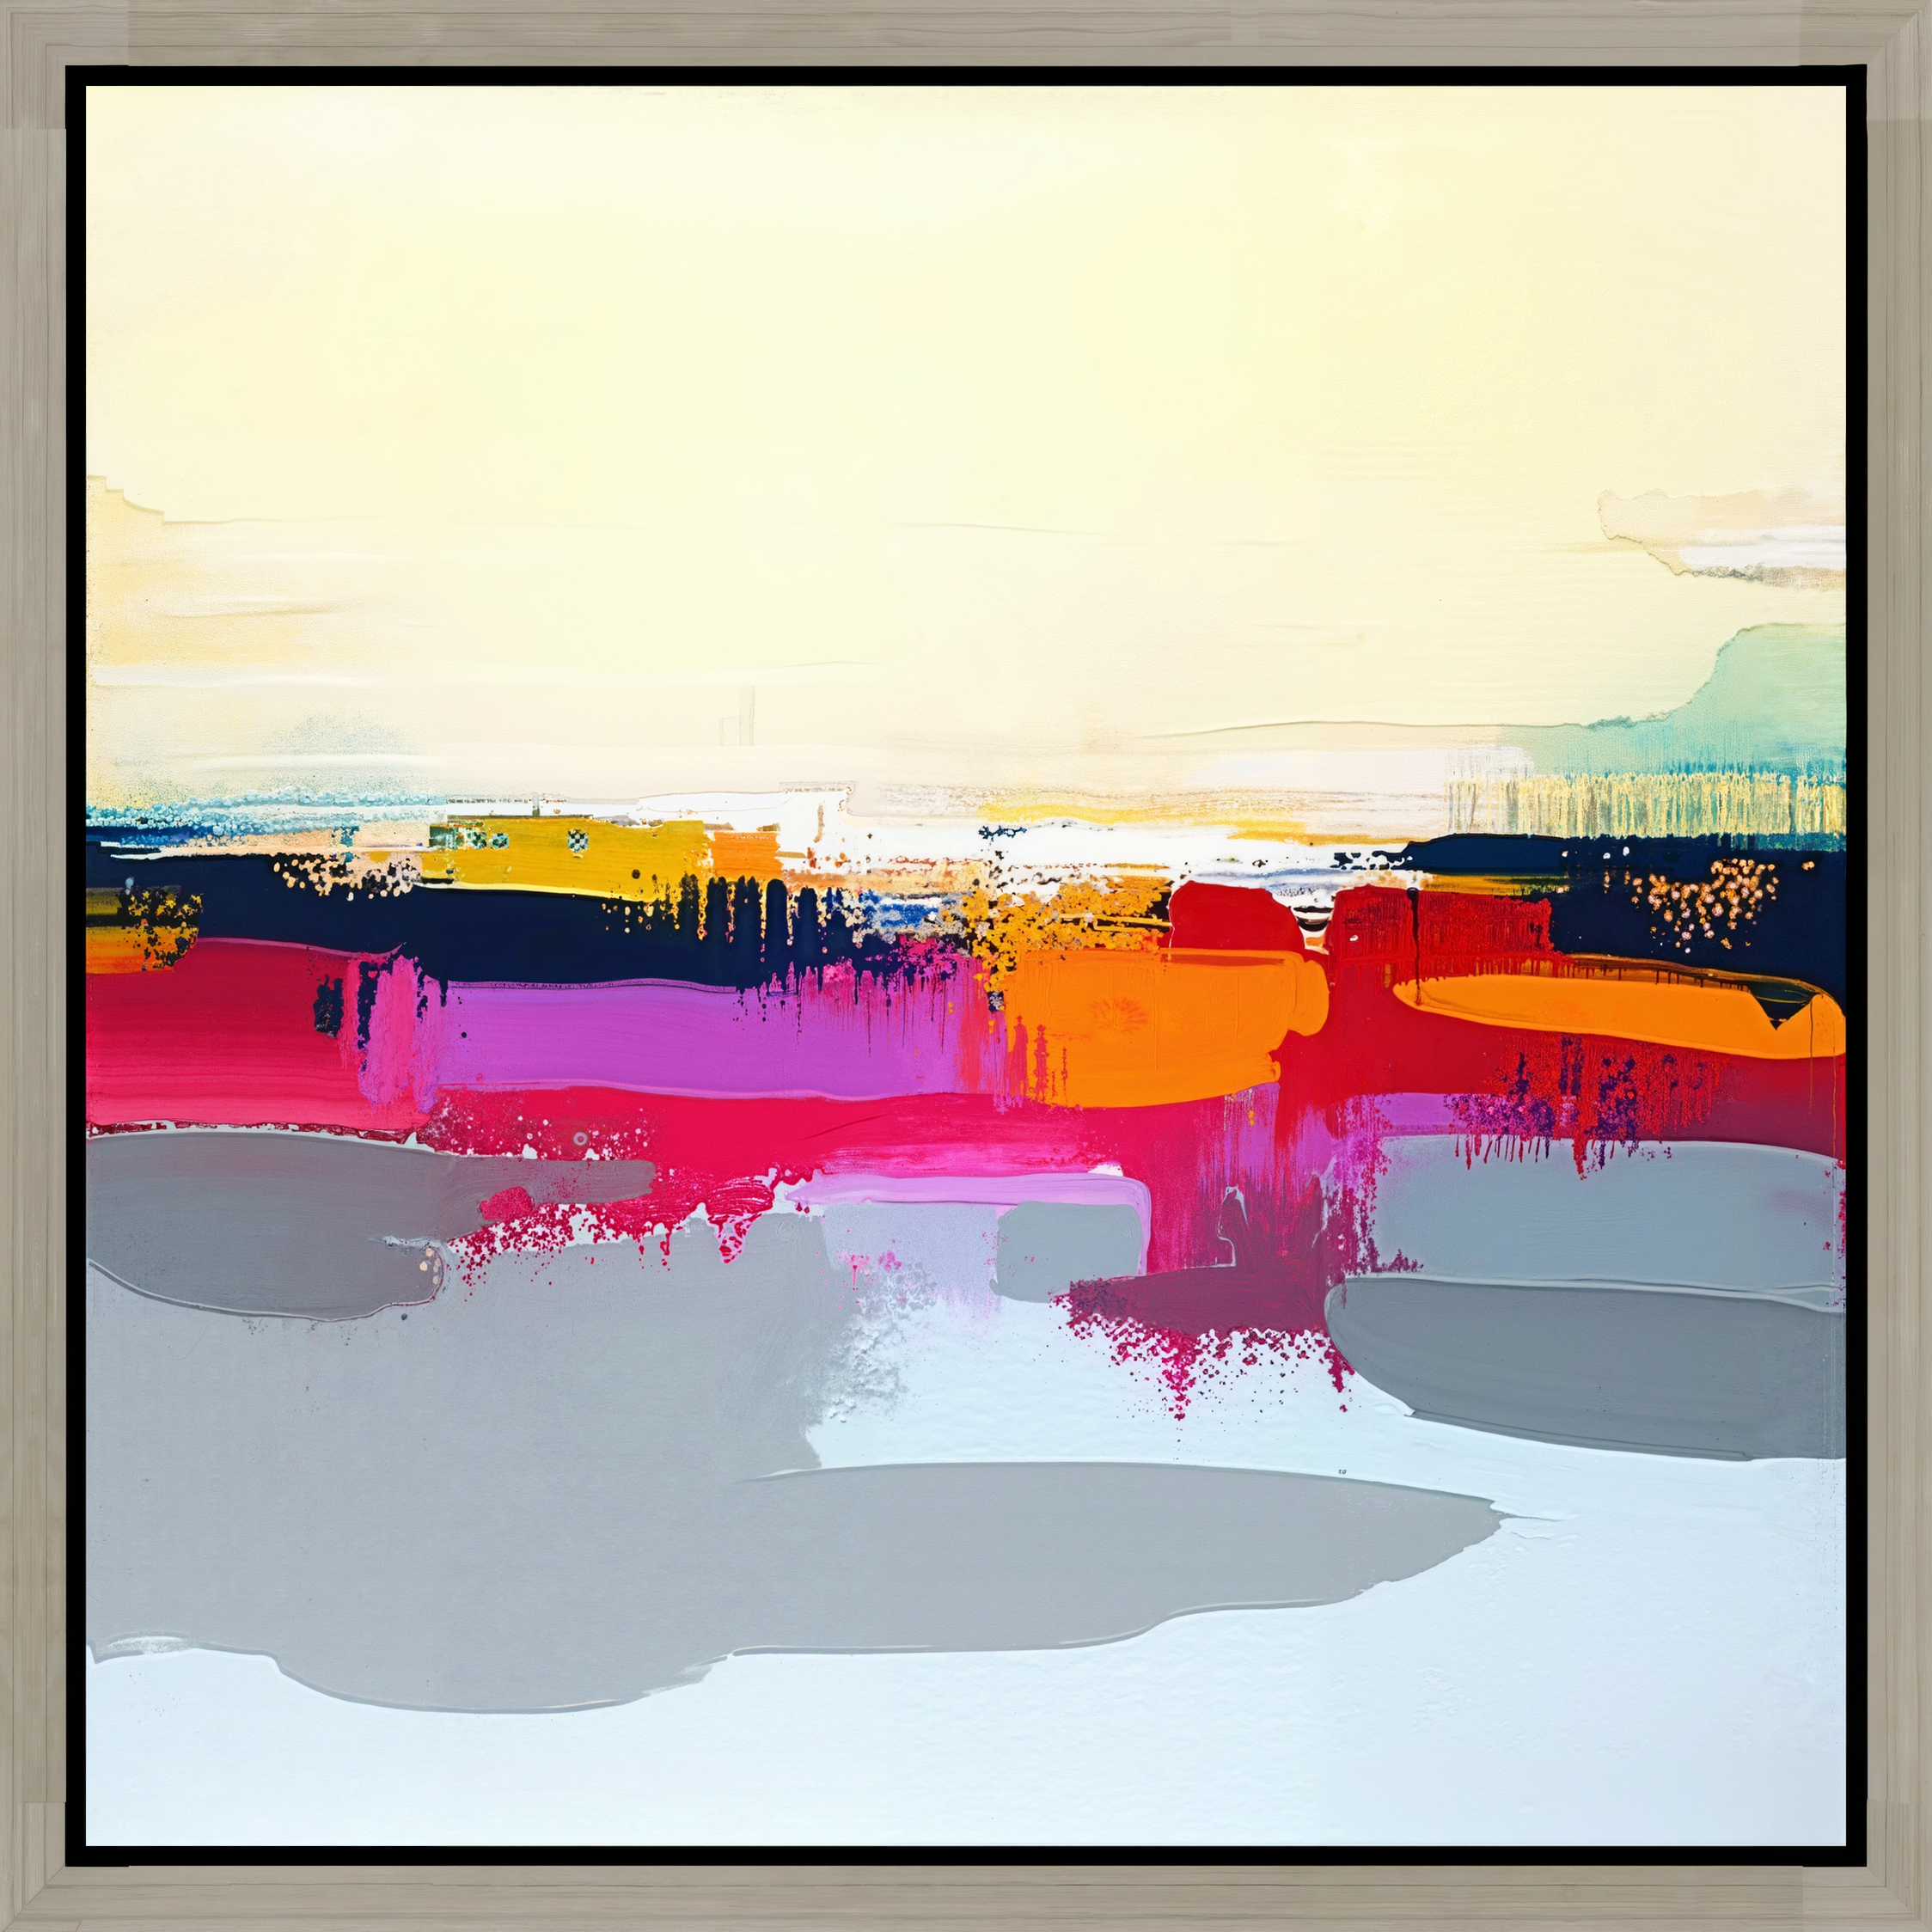


✅ Upscaling complete!


In [5]:
# @title Upscale Image/Video

def upscale_input(
    image_path: str,
    positive_prompt: str,
    positive_prompt2: str,
    negative_prompt: str,
    negative_prompt2: str,
    guidance: float,
    upscale_by: float,
    seed: int,
    steps: int,
    cfg: float,
    sampler_name: str,
    scheduler: str,
    denoise: float,
    upscale_model_name: str,
    mode_type: str,
    tile_width: int,
    tile_height: int,
    mask_blur: int,
    tile_padding: int,
    seam_fix_mode: str,
    seam_fix_denoise: float,
    seam_fix_width: int,
    seam_fix_mask_blur: int,
    seam_fix_padding: int,
    force_uniform_tiles: bool,
    tiled_decode: bool,
    select_every_nth: int,
    skip_first_frames: int,
    max_output_frames: int,
    overwrite: bool,
    use_lora: bool,
    lora_strength: float,
    remove_frame: bool = False,
    frame_removal_threshold: float = 0.15,
    min_frame_width: int = 10,
    max_frame_width: int = 200
):
    # Resolve image path
    image_path = Path(image_path)
    if not image_path.is_absolute():
        image_path = REPO_ROOT / image_path
    
    if not image_path.exists():
        raise FileNotFoundError(f"Input file not found: {image_path}")
    
    print(f"Processing: {image_path}")
    
    # Remove frame if requested (only for images, not videos)
    original_image_path = image_path
    if remove_frame and str(image_path).lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
        print("Removing frame from image...")
        try:
            image_path = Path(remove_frame(
                str(image_path),
                threshold=frame_removal_threshold,
                min_frame_width=min_frame_width,
                max_frame_width=max_frame_width
            ))
            print(f"Using frame-removed image: {image_path}")
        except Exception as e:
            print(f"Warning: Frame removal failed ({e}), using original image")
            image_path = original_image_path

    with torch.inference_mode():
        print("Loading Text_Encoder...")
        # Pass just filenames - folder_paths is configured to look in our custom directories
        clip = clip_loader.load_clip(flux_t5xxl, flux_clip_l, "flux")[0]

        positive = positive_prompt_encode.encode(clip, positive_prompt, positive_prompt2, guidance)[0]
        negative = negative_prompt_encode.encode(clip, negative_prompt, negative_prompt2, guidance)[0]

        del clip
        torch.cuda.empty_cache()
        gc.collect()

        print("Loading Unet Model...")
        model = unet_loader.load_unet(flux_model)[0]

        print("Loading upscale model...")
        upscale_model_load = upscale_model_loader.load_model(upscale_model_name)[0]

        print("Loading VAE...")
        vae = vae_loader.load_vae(flux_vae)[0]

        if use_lora and lora is not None:
            print("Loading LoRA...")
            model = load_lora.load_lora_model_only(model, lora, lora_strength)[0]

        # Extract image name from input path and create output name
        image_name = image_path.stem  # Gets filename without extension
        base_name = f"{image_name}-upscaled"

        try:
            if str(image_path).lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
                # Single image processing
                loaded_image = load_image.load_image(str(image_path))[0]
                print("Upscaling image...")
                image_out = upscaler.upscale(
                    image=loaded_image,
                    model=model,
                    positive=positive,
                    negative=negative,
                    vae=vae,
                    upscale_by=upscale_by,
                    seed=seed,
                    steps=steps,
                    cfg=cfg,
                    sampler_name=sampler_name,
                    scheduler=scheduler,
                    denoise=denoise,
                    upscale_model=upscale_model_load,
                    mode_type=mode_type,
                    tile_width=tile_width,
                    tile_height=tile_height,
                    mask_blur=mask_blur,
                    tile_padding=tile_padding,
                    seam_fix_mode=seam_fix_mode,
                    seam_fix_denoise=seam_fix_denoise,
                    seam_fix_mask_blur=seam_fix_mask_blur,
                    seam_fix_width=seam_fix_width,
                    seam_fix_padding=seam_fix_padding,
                    force_uniform_tiles=force_uniform_tiles,
                    tiled_decode=tiled_decode,
                )[0]

                print("Saving as PNG image...")
                output_path = save_as_image(image_out[0], base_name)
                print(f"Saved to: {output_path}")
                display(IPImage(filename=output_path))

            else:
                # Video processing
                frames, fps = extract_frames(image_path)
                frames, fps = select_every_n_frame(frames, fps, select_every_nth, skip_first_frames, max_output_frames)
                upscaled_frames = []

                for i, frame in enumerate(frames):
                    temp_path = REPO_ROOT / "temp_frame.png"
                    cv2.imwrite(str(temp_path), cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
                    loaded_image = load_image.load_image(str(temp_path))[0]

                    print(f"Upscaling frame {i+1} of {len(frames)} frames...")

                    upscaled_frame = upscaler.upscale(
                        image=loaded_image,
                        model=model,
                        positive=positive,
                        negative=negative,
                        vae=vae,
                        upscale_by=upscale_by,
                        seed=seed,
                        steps=steps,
                        cfg=cfg,
                        sampler_name=sampler_name,
                        scheduler=scheduler,
                        denoise=denoise,
                        upscale_model=upscale_model_load,
                        mode_type=mode_type,
                        tile_width=tile_width,
                        tile_height=tile_height,
                        mask_blur=mask_blur,
                        tile_padding=tile_padding,
                        seam_fix_mode=seam_fix_mode,
                        seam_fix_denoise=seam_fix_denoise,
                        seam_fix_mask_blur=seam_fix_mask_blur,
                        seam_fix_width=seam_fix_width,
                        seam_fix_padding=seam_fix_padding,
                        force_uniform_tiles=force_uniform_tiles,
                        tiled_decode=tiled_decode
                    )[0]
                    upscaled_frames.append(upscaled_frame)

                # Clean up temp file
                if temp_path.exists():
                    temp_path.unlink()

                print(f"Saving as MP4 with {len(upscaled_frames)} frames...")
                output_path = save_as_mp4(upscaled_frames, base_name, fps)
                print(f"Saved to: {output_path}")
                display_video(output_path)

        finally:
            # Clean up temporary frame-removed image if it was created
            if remove_frame and image_path != original_image_path and image_path.exists():
                try:
                    image_path.unlink()
                    print(f"Cleaned up temporary frame-removed image: {image_path}")
                except Exception as e:
                    print(f"Warning: Could not delete temporary image {image_path}: {e}")
            
            del model
            del vae
            del upscale_model_load
            clear_memory()

# Set random seed if 0
actual_seed = seed if seed != 0 else random.randint(0, 2**32 - 1)
print(f"Using seed: {actual_seed}")

# Run upscaling
upscale_input(
    image_path=INPUT_IMAGE_PATH,
    positive_prompt=positive_prompt,
    positive_prompt2=positive_prompt2,
    negative_prompt=negative_prompt,
    negative_prompt2=negative_prompt2,
    guidance=guidance,
    upscale_by=upscale_by,
    seed=actual_seed,
    steps=steps,
    cfg=cfg,
    sampler_name=sampler_name,
    scheduler=scheduler,
    denoise=denoise,
    upscale_model_name=upscale_model,
    mode_type=mode_type,
    tile_width=tile_width,
    tile_height=tile_height,
    mask_blur=mask_blur,
    tile_padding=tile_padding,
    seam_fix_mode=seam_fix_mode,
    seam_fix_denoise=seam_fix_denoise,
    seam_fix_width=seam_fix_width,
    seam_fix_mask_blur=seam_fix_mask_blur,
    seam_fix_padding=seam_fix_padding,
    force_uniform_tiles=force_uniform_tiles,
    tiled_decode=tiled_decode,
    select_every_nth=select_every_nth_frame,
    skip_first_frames=skip_first_frames,
    max_output_frames=max_output_frames,
    overwrite=overwrite_previous_output,
    use_lora=use_loRA,
    lora_strength=LoRA_Strength,
    remove_frame=remove_frame_before_upscale,
    frame_removal_threshold=frame_removal_threshold,
    min_frame_width=min_frame_width,
    max_frame_width=max_frame_width
)

print("\n✅ Upscaling complete!")